In [ ]:
%matplotlib inline
import pandas as pd
import networkx as nx
!pip install fuzzywuzzy
!pip install python-Levenshtein
from fuzzywuzzy import fuzz
import random
import matplotlib.pyplot as plt
from matplotlib import collections as mc
import warnings
import numpy as np
from numpy import exp
import plotly.graph_objects as go
import statistics
import time
import os
# from apgl.graph import VertexList
from scipy.io import mmread, mminfo
import networkx as nx 
warnings.filterwarnings('ignore')
from scipy.stats import truncnorm
import math
import heapq
import time

     |████████████████████████████████| 51kB 4.8MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149803 sha256=be70db692d5898b376dc55e31cf61b7c256817b3ed056c130b9353b1eae1617e
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [ ]:
#! pip install pandas-profiling==2.7.1

In [ ]:
# from pandas_profiling import ProfileReport

In [ ]:
target_df = pd.read_csv("https://bitbucket.org/hari_narayanan_123/us_patents/raw/24a72c5789d3bacc4be3cc97aadd7aa08c3d1350/apat63_99.txt")
edge_df = pd.read_csv("https://bitbucket.org/hari_narayanan_123/us_patents/raw/24a72c5789d3bacc4be3cc97aadd7aa08c3d1350/cit-Patents.csv", sep="\t")
subcategory_df = pd.read_csv("https://bitbucket.org/hari_narayanan_123/us_patents/raw/6f2b72376fdb2ab11cdbd116bcc8c2c6f7dcc2a4/subcategories.txt", sep="\t")
class_df = pd.read_csv("https://bitbucket.org/hari_narayanan_123/us_patents/raw/6f2b72376fdb2ab11cdbd116bcc8c2c6f7dcc2a4/list_of_classes.txt", sep="\t")
country_df = pd.read_csv("https://bitbucket.org/hari_narayanan_123/us_patents/raw/a2ea6e59602867e94ce5890c2c0adb6a4bd8d23f/list_of_countries.txt", sep="\t")

In [ ]:
edge_df = edge_df.dropna()
edge_df = edge_df.reset_index(drop=True)
edge_df.head()

,FromNodeId,ToNodeId
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


In [ ]:
# edge_df['ToNodeId'] = edge_df['ToNodeId'].fillna(0.0).astype(int)
edge_df['ToNodeId'] = edge_df['ToNodeId'].astype(int)
edge_df['ToNodeId'].dtype

dtype('int64')

In [ ]:
edge_df.head()

,FromNodeId,ToNodeId
0,3858241,956203
1,3858241,1324234
2,3858241,3398406
3,3858241,3557384
4,3858241,3634889


Preprocess the edge df

In [ ]:
target_df = target_df.dropna()
target_df = target_df.reset_index(drop=True)
target_df.head()

,PATENT,GYEAR,GDATE,APPYEAR,COUNTRY,POSTATE,ASSIGNEE,ASSCODE,CLAIMS,NCLASS,CAT,SUBCAT,CMADE,CRECEIVE,RATIOCIT,GENERAL,ORIGINAL,FWDAPLAG,BCKGTLAG,SELFCTUB,SELFCTLB,SECDUPBD,SECDLWBD
0,3858245,1975,5485,1972.0,US,NY,237715.0,2,5.0,623,3,39,7.0,11,0.8571,0.4959,0.2778,6.4545,9.2857,0.0,0.0000,0.00,0.00
1,3858251,1975,5485,1973.0,US,WI,445930.0,2,17.0,4,6,65,7.0,3,0.5714,0.4444,0.0000,3.3333,23.7143,1.0,0.1429,0.00,0.00
2,3858262,1975,5485,1973.0,US,MA,601600.0,2,8.0,470,5,59,6.0,4,1.0000,0.0000,0.6667,13.5000,5.3333,0.5,0.3333,0.25,0.25
3,3858264,1975,5485,1973.0,US,WI,309400.0,2,8.0,14,6,69,6.0,6,1.0000,0.0000,0.0000,10.6667,7.5000,0.0,0.0000,0.00,0.00
4,3858269,1975,5485,1973.0,US,MI,435140.0,2,5.0,16,5,59,4.0,11,0.2500,0.6446,0.0000,20.0000,15.7500,0.0,0.0000,0.00,0.00


In [ ]:
target_df = target_df.drop(columns=['FWDAPLAG', 'BCKGTLAG', 'SELFCTUB', 'SELFCTLB', 'SECDUPBD', 'SECDLWBD'])
target_df.head()

,PATENT,GYEAR,GDATE,APPYEAR,COUNTRY,POSTATE,ASSIGNEE,ASSCODE,CLAIMS,NCLASS,CAT,SUBCAT,CMADE,CRECEIVE,RATIOCIT,GENERAL,ORIGINAL
0,3858245,1975,5485,1972.0,US,NY,237715.0,2,5.0,623,3,39,7.0,11,0.8571,0.4959,0.2778
1,3858251,1975,5485,1973.0,US,WI,445930.0,2,17.0,4,6,65,7.0,3,0.5714,0.4444,0.0000
2,3858262,1975,5485,1973.0,US,MA,601600.0,2,8.0,470,5,59,6.0,4,1.0000,0.0000,0.6667
3,3858264,1975,5485,1973.0,US,WI,309400.0,2,8.0,14,6,69,6.0,6,1.0000,0.0000,0.0000
4,3858269,1975,5485,1973.0,US,MI,435140.0,2,5.0,16,5,59,4.0,11,0.2500,0.6446,0.0000


In [ ]:
subcategory_df = subcategory_df.dropna()
class_df = class_df.dropna()
country_df = country_df.dropna()
subcategory_df = subcategory_df.drop(columns=['CatNameShort'])
country_df = country_df.dropna()  

In [ ]:
features_df = target_df.merge(class_df, left_on='NCLASS', right_on='Class')
features_df = features_df.drop(columns=['NCLASS', 'Class'])

In [ ]:
cat_df = features_df.merge(subcategory_df, left_on=['CAT', 'SUBCAT'], right_on=['Cat', 'SubCat'])
cat_df = cat_df.drop(columns=['CAT', 'SUBCAT', 'Cat', 'SubCat'])

In [ ]:
state_df = cat_df.merge(country_df, left_on=['POSTATE'], right_on=['Code'])
features_df = state_df.drop(columns=['COUNTRY', 'POSTATE', 'ASSIGNEE', 'ASSCODE', 'Code'])

In [ ]:
features_df.columns

Index(['PATENT', 'GYEAR', 'GDATE', 'APPYEAR', 'CLAIMS', 'CMADE', 'CRECEIVE',
       'RATIOCIT', 'GENERAL', 'ORIGINAL', 'Title', 'SubCatName', 'CatNameLong',
       'U.S.State '],
      dtype='object')

In [ ]:
features_df.head()

,PATENT,GYEAR,GDATE,APPYEAR,CLAIMS,CMADE,CRECEIVE,RATIOCIT,GENERAL,ORIGINAL,Title,SubCatName,CatNameLong,U.S.State
0,3858245,1975,5485,1972.0,5.0,7.0,11,0.8571,0.4959,0.2778,"Prosthesis (i.e., Artificial Body Members), Pa...",Miscellaneous-Drgs&Med,Drugs&Medical,NEW YORK
1,3885251,1975,5625,1973.0,8.0,5.0,10,0.8000,0.7000,0.5000,"Prosthesis (i.e., Artificial Body Members), Pa...",Miscellaneous-Drgs&Med,Drugs&Medical,NEW YORK
2,3906552,1975,5744,1974.0,7.0,4.0,7,0.2500,0.4490,0.0000,"Prosthesis (i.e., Artificial Body Members), Pa...",Miscellaneous-Drgs&Med,Drugs&Medical,NEW YORK
3,3914801,1975,5779,1971.0,10.0,8.0,9,0.7500,0.4444,0.5000,"Prosthesis (i.e., Artificial Body Members), Pa...",Miscellaneous-Drgs&Med,Drugs&Medical,NEW YORK
4,3952335,1976,5961,1974.0,15.0,2.0,16,0.5000,0.3750,0.0000,"Prosthesis (i.e., Artificial Body Members), Pa...",Miscellaneous-Drgs&Med,Drugs&Medical,NEW YORK


In [ ]:
# len(features_df)

In [ ]:
# profile = ProfileReport(df=features_df)
# profile.to_file(output_file="features_data.html")

In [ ]:
print(edge_df['FromNodeId'].min())
print(edge_df['ToNodeId'].min())
print(features_df['PATENT'].min())

3858241
1
3858245


In [ ]:
unique_patents = pd.unique(edge_df[['FromNodeId', 'ToNodeId']].values.ravel('K'))
unique_feature_patents = pd.unique(features_df['PATENT'].values.ravel('K'))
patents_without_features = pd.DataFrame(set(unique_patents) - set(unique_feature_patents))

Get the new edge list by removing those nodes that dont have their corresponding features present

In [ ]:
print(patents_without_features[0].head())
new_edge_df = edge_df[~edge_df['FromNodeId'].isin(patents_without_features[0])]
new_edge_df = new_edge_df[~new_edge_df['ToNodeId'].isin(patents_without_features[0].values)]

0     1
1    13
2    24
3    29
4    31
Name: 0, dtype: int64


Verify that now there is no patent whoose features are not present among the new patent edge list

In [ ]:
unique_patents = pd.unique(new_edge_df[['FromNodeId', 'ToNodeId']].values.ravel('K'))
unique_feature_patents = features_df.index.values.ravel('K')
patents_without_features = pd.DataFrame(set(unique_patents) - set(unique_feature_patents))
len(patents_without_features)

633587

In [ ]:
unique_patent_values = []
unique_patent_values = list(set(new_edge_df['FromNodeId'].tolist()))
unique_patent_values.extend(list(set(new_edge_df['ToNodeId'].tolist())))
len(unique_patent_values)

980594

In [ ]:
# patent_map = {}
# unique_patent_values.sort()
# for i,j in zip(unique_patent_values, range(len(unique_patent_values))):
#   patent_map[i] = j
# len(patent_map)

In [ ]:
# patent_map

In [ ]:
# modified_edge_df = new_edge_df.copy(deep=False)
# new_edge_df.replace({"FromNodeId": patent_map})
# new_edge_df.replace({"ToNodeId": patent_map})
# new_edge_df["FromNodeId"].replace(patent_map, inplace=True)
# new_edge_df["ToNodeId"].replace(patent_map, inplace=True)
# new_edge_df["FromNodeId"].map(patent_map).fillna(0)
# new_edge_df["ToNodeId"].map(patent_map).fillna(0)
# len(new_edge_df)

In [ ]:
# new_edge_df.to_csv('new_patents_df.csv',  index=False)

In [ ]:
G = nx.from_pandas_edgelist(new_edge_df, source='FromNodeId', target='ToNodeId', create_using=nx.DiGraph())

Average Degree of all nodes

In [ ]:
tot_degree = node_count = 0
for node in G.nodes():
  tot_degree = tot_degree+ G.degree(node)
  node_count = node_count+1
avg_degree = tot_degree/node_count
avg_degree

7.188989041757486

In [ ]:
# print(sum(degrees.values()))

Degree Centrality based Algo --> Getting top 5 nodes based on their Degree

In [ ]:
start_time = time.time()
li = [()];
heapq.heapify(li)
for node in G.nodes():
  deg = G.degree[node];
  heapq.heappush(li,(deg,node));
  if len(li) > 20:
    heapq.heappop(li)
li.sort(key=lambda x:x[0],reverse=True)
end_time = (time.time() - start_time);

In [ ]:
print(list(li))
print("Time taken is ",end_time)
for i,j in li:
  print("Deg "+ str(i), "Node is "+ str(j));

[(308, 5848246), (246, 4683195), (223, 5808797), (222, 5841579), (208, 5797877), (203, 5610317), (191, 5792534), (190, 5747594), (190, 5773106), (187, 4733665), (185, 4870302), (184, 4440871), (180, 4901307), (178, 4387297), (176, 4234435), (173, 5681380), (171, 3953566), (168, 4228496), (167, 3864154), (167, 4100324)]
Time taken is  1.585465669631958
Deg 308 Node is 5848246
Deg 246 Node is 4683195
Deg 223 Node is 5808797
Deg 222 Node is 5841579
Deg 208 Node is 5797877
Deg 203 Node is 5610317
Deg 191 Node is 5792534
Deg 190 Node is 5747594
Deg 190 Node is 5773106
Deg 187 Node is 4733665
Deg 185 Node is 4870302
Deg 184 Node is 4440871
Deg 180 Node is 4901307
Deg 178 Node is 4387297
Deg 176 Node is 4234435
Deg 173 Node is 5681380
Deg 171 Node is 3953566
Deg 168 Node is 4228496
Deg 167 Node is 3864154
Deg 167 Node is 4100324


Single Degree Discount Algorithm


In [ ]:
start_time = time.time()
G_sing_deg_dis = G.copy();
li_deg_dis = [];
k = 20;
for i in range(k):
  max_deg = -1;
  for node in G_sing_deg_dis.nodes():
    deg = G_sing_deg_dis.degree[node];
    if deg > max_deg:
      rem_node = node;
      max_deg = deg;
  li_deg_dis.append((rem_node,max_deg));
  G_sing_deg_dis.remove_node(rem_node);
end_time = (time.time() - start_time);
print("Time taken is ",end_time)

Time taken is  31.193522930145264


In [ ]:
S_sin_deg_discount = []
for node,deg in li_deg_dis:
  S_sin_deg_discount.append(node)

In [ ]:
li_deg_dis

[(5848246, 308),
 (4683195, 246),
 (5808797, 223),
 (5841579, 222),
 (5797877, 208),
 (5610317, 203),
 (5792534, 191),
 (5747594, 190),
 (5773106, 190),
 (4733665, 187),
 (4870302, 185),
 (4440871, 184),
 (4901307, 180),
 (4387297, 178),
 (4234435, 176),
 (5681380, 173),
 (3953566, 171),
 (4228496, 168),
 (3864154, 167),
 (4100324, 167)]

Degree Discount Algorithm


In [ ]:
start_time = time.time()
G_degree_discount = G.copy();
max_patent=-1;
for node in G.nodes():
  max_patent = max(max_patent,node)
#V = G_degree_discount.number_of_nodes();
ddv = [None] * (max_patent+1);
tv = [0] * (max_patent+1);
p = 0.01;
k = 20;
S = [];
for node in G_degree_discount.nodes():
  degree = G_degree_discount.degree[node];
  ddv[node] = degree;
for i in range(k):
  max_deg = -1;
  u = -1;
  for node in G_degree_discount.nodes():
    deg = ddv[node];
    if deg > max_deg and node not in S:
      u = node;
      max_deg = deg;
  S.append(u);
  neighbour_list = list(G_degree_discount.neighbors(u));
  for v in neighbour_list:
    if v in S:
      continue
    tv[v] = tv[v] + 1;
    dv = G_degree_discount.degree[v];
    ddv[v] = dv - 2*tv[v] - (dv-tv[v])*tv[v]*p;
end_time = (time.time() - start_time);
print("Time taken is ",end_time)

Time taken is  16.728244304656982


In [ ]:
S_deg_discount = S
for node in S_deg_discount:
  print("Node is " + str(node),"Discounted Degree is "+ str(ddv[node]))

Node is 5848246 Discounted Degree is 308
Node is 4683195 Discounted Degree is 246
Node is 5808797 Discounted Degree is 223
Node is 5841579 Discounted Degree is 222
Node is 5797877 Discounted Degree is 208
Node is 5610317 Discounted Degree is 203
Node is 5792534 Discounted Degree is 191
Node is 5747594 Discounted Degree is 190
Node is 5773106 Discounted Degree is 190
Node is 4733665 Discounted Degree is 187
Node is 4870302 Discounted Degree is 185
Node is 4440871 Discounted Degree is 184
Node is 4901307 Discounted Degree is 180
Node is 4387297 Discounted Degree is 178
Node is 4234435 Discounted Degree is 176
Node is 5681380 Discounted Degree is 173
Node is 3953566 Discounted Degree is 171
Node is 4228496 Discounted Degree is 168
Node is 3864154 Discounted Degree is 167
Node is 4100324 Discounted Degree is 167


In [ ]:
#  new_edge_df.to_csv('patents_df.csv')

In [ ]:
nx.is_directed(G)

True

In [ ]:
nx.is_weakly_connected(G)

False

In [ ]:
patent_list = list(features_df['PATENT'])

In [ ]:
tweak_features = features_df
tweak_features.set_index("PATENT",  
              inplace = True) 

In [ ]:
for patent in patent_list:
  result = tweak_features.loc[patent]
  if patent in G.nodes():
    G.nodes[patent]['grant_year'] = result['GYEAR']
    G.nodes[patent]['title'] = result['Title']
    G.nodes[patent]['sub_category'] = result['SubCatName']
    G.nodes[patent]['category'] = result['CatNameLong']

In [ ]:
G.nodes[5409845]['title']

'Semiconductor Device Manufacturing: Process'

Checking if all the nodes in the graph are having features associated with it


In [ ]:
flag = True 
for node in G.nodes():
  node_attribute_dict = G.nodes[node]
  if node_attribute_dict.get('title') is None:
    flag = False
    break
print(flag)

True


In [ ]:
#nx.set_node_attributes(G, pd.Series(features_df.PATENT, index=features_df.PATENT).to_dict(), 'patent')
#nx.set_node_attributes(G, pd.Series(features_df.GYEAR, index=features_df.PATENT).to_dict(), 'grant_year')
#nx.set_node_attributes(G, pd.Series(features_df.Title, index=features_df.PATENT).to_dict(), 'title')
#nx.set_node_attributes(G, pd.Series(features_df.SubCatName, index=features_df.PATENT).to_dict(), 'sub_category')

In [ ]:
print(G.nodes[3858245])

{'grant_year': 1975, 'title': 'Prosthesis (i.e., Artificial Body Members), Parts Thereof, or Aids and Accessories Therefor', 'sub_category': 'Miscellaneous-Drgs&Med', 'category': 'Drugs&Medical'}


In [ ]:
q = "Semiconductor"

In [ ]:
max_M = -1;
for node in G.nodes():
  G.nodes[node]['Matching Score'] =  fuzz.token_set_ratio(q, G.nodes[node]['title'])/100
  max_M = max(max_M,G.nodes[node]['Matching Score'])


In [ ]:
max_M


1.0

In [ ]:
mi_nodes = []
threshold = 0.99
for nodes in G.nodes():
  if G.nodes[nodes]['Matching Score'] > threshold:
    mi_nodes.append(nodes)

In [ ]:
len(mi_nodes)

7293

In [ ]:
target_df['CAT'].unique()

array([3, 6, 5, 1, 4, 2])

In [ ]:
V = G.number_of_nodes()
E = G.number_of_edges()

In [ ]:
print(V,E)


633587 2277425


In [ ]:
# nx.write_gexf(G, "Patent_Graph.gexf") 

In [ ]:
max_patent = -1
min_patent = 10**10
for node in G.nodes():
  max_patent = max(max_patent,node)
  min_patent = min(min_patent,node)

In [ ]:
print(min_patent,max_patent)

3858245 5855020


In [ ]:
a = [1,"2assa",3]
b = ["2assa",4,5]
c = list(set(a) & set(b))
d = list(set(a) | set(b))
print(c)

['2assa']


In [ ]:
for u,v in G.edges():
  u_sub_category = []
  u_category = []
  v_sub_category = []
  v_category = []
  u_neighbour_list = list(G.neighbors(u))
  v_neighbour_list = list(G.neighbors(v))
  
  for node in u_neighbour_list:
    u_sub_category.append(G.nodes[node]['sub_category'])
    u_category.append(G.nodes[node]['category'])
  
  for node in v_neighbour_list:
    v_sub_category.append(G.nodes[node]['sub_category'])
    v_category.append(G.nodes[node]['category'])
  
  sc_intersection = list(set(u_sub_category) & set(v_sub_category))
  sc_union = list(set(u_sub_category) | set(v_sub_category))
  sc_jaccard = len(sc_intersection)/len(sc_union)

  c_intersection = list(set(u_category) & set(v_category))
  c_union = list(set(u_category) | set(v_category))
  c_jaccard = len(c_intersection)/len(c_union)

  G[u][v]['weight'] = 0.75*sc_jaccard+0.25*c_jaccard


In [ ]:
benefit = [[] for _ in range(max_patent+1)]
loss = [[] for _ in range(max_patent+1)]

In [ ]:
for node in G.nodes():
  benefit[node].append(0)
  loss[node].append(0)

In [ ]:
error = 1
threshold = 10 ** (-10)
k=0;
alpha = 0.85
beta = 0.85
lamda = 0.5
query = 5855020 

In [ ]:
# list(G.neighbors(5855020))
G.nodes[5855020]

{'Matching Score': 0.25,
 'category': 'Computers&Communications',
 'grant_year': 1998,
 'sub_category': 'Computer Hardware & Software',
 'title': 'Data Processing:  Database and File Management, Data Structures, or Document Processing'}

In [ ]:
query_neighbor_mi_list = []
for node in list(G.neighbors(5855020)):
  query_neighbor_mi_list.append(G.nodes[node]['Matching Score'])
query_neighbor_mi_list.sort()
opt_lambda = statistics.median(query_neighbor_mi_list)
print(opt_lambda)

0.25


Algorithm 1 -- hyper parameters(alpha,beta,lambda) have to be set and query node also has to be identified so that we can proceed further

In [ ]:
def ComputeBLScore(it=4, alpha=0.85, beta=0.85, lamda=0.5 ):
  
  benefit = [[] for _ in range(max_patent+1)]
  loss = [[] for _ in range(max_patent+1)]
  
  for node in G.nodes():
    benefit[node].append(0)
    loss[node].append(0)

  k=0
  
  while k < it:
    k+=1;
    for node in G.nodes():
      benefit[node].append(0)
      loss[node].append(0);
      neighbour_list = list(G.neighbors(node))
      for neighbour in neighbour_list:
        benefit[node][k] += (G[node][neighbour]['weight'])*(1-lamda)*(alpha*benefit[neighbour][k-1] + (1-alpha)*G.nodes[neighbour]['Matching Score'])/E
        loss[node][k] += (G[node][neighbour]['weight'])*(beta*loss[neighbour][k-1] + (1-beta)*(1-G.nodes[neighbour]['Matching Score']))/E
    ## query node 
    benefit[query][k] += lamda/V;
    error = 0;
    for i in G.nodes():
      val = ((benefit[i][k]-benefit[i][k-1])**2 + (loss[i][k]-loss[i][k-1])**2)
      #print(val,"HI")
      error += ((benefit[i][k]-benefit[i][k-1])**2 + (loss[i][k]-loss[i][k-1])**2) + (math.exp(-10))*(1/((alpha)**2) + 1/((beta)**2))
    error = error ** 0.5
  return error

Variation of Parameter Values --> For alpha and beta we go ahead with random sampling from a uniform distribution and optimise the error function. The optimisation is a minimisation one as we aim to minimise the error. We iterate over 100 different iterations each one sampling an alpha beta from uniform distribution.

This function is a truncated normal distribution function which ensures that each value drawn is from 0 to 1 as alpha and beta cant be ngative and is in between 0 and 1

In [ ]:
def get_truncated_normal(mean=0, sd=1, low=0, upp=1):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

Change range to 100 and run when time permits

In [ ]:
def normalDist(it=20):
  min_error = float('inf')
  opt_alpha = 0.85
  opt_beta = 0.85
  k = 0
  for it in range(1,it):
      alpha = get_truncated_normal(mean=0, sd=1, low=0, upp=1).rvs()
      beta =  get_truncated_normal(mean=0, sd=1, low=0, upp=1).rvs()
      curr_error =  ComputeBLScore(alpha=alpha, beta=beta, lamda=opt_lambda)
      if curr_error<min_error:
        min_error = curr_error
        opt_alpha = alpha
        opt_beta = beta
  return (opt_alpha,opt_beta,min_error)    

In [ ]:
def uniformDist(it=20):
  min_error = float('inf')
  opt_alpha = 0.85
  opt_beta = 0.85
  k = 0
  for it in range(1,it):
    alpha = np.random.uniform(0, 1, 1)
    beta = np.random.uniform(0, 1, 1)
    curr_error = ComputeBLScore(alpha=alpha, beta=beta, lamda=opt_lambda)
    if curr_error<min_error:
      min_error = curr_error
      opt_alpha = alpha
      opt_beta = beta
  return (opt_alpha,opt_beta,min_error)

In [ ]:
# opt_alpha_normal, opt_beta_normal, min_error_normal = normalDist(it=5)

In [ ]:
# opt_alpha_uniform, opt_beta_uniform, min_error_uniform = uniformDist(it=5)

Print optimum alpha beta for uniform and normal distributions

In [ ]:
# print("Normal Distribution",min_error_normal)
# print("Opt Alpha is",opt_alpha_normal, "Opt Beta is",opt_beta_normal, "Opt Lambda is",opt_lambda)

In [ ]:
# print("Uniform Distribution",min_error_uniform)
# print("Opt Alpha is",opt_alpha_uniform, "Opt Beta is",opt_beta_uniform, "Opt Lambda is",opt_lambda)

In [ ]:
# opt_alpha = opt_alpha_normal if min_error_normal<=min_error_uniform else opt_alpha_uniform
# opt_beta = opt_beta_normal if min_error_normal<=min_error_uniform else opt_beta_uniform

In [ ]:
# opt_alpha,opt_beta

In [ ]:
opt_alpha=0.845
opt_beta = 0.901

In [ ]:
start_time = time.time()
error = 1
threshold = 10 ** (-10)
k=0;
alpha = opt_alpha
beta = opt_beta
lamda = opt_lambda
benefit = [[] for _ in range(max_patent+1)]
loss = [[] for _ in range(max_patent+1)]
for i in G.nodes():
    benefit[i].append(0)
    loss[i].append(0)
while error > threshold:
  k+=1;
  for node in G.nodes():
    benefit[node].append(0)
    loss[node].append(0);
    neighbour_list = list(G.neighbors(node))
    for neighbour in neighbour_list:
      benefit[node][k] += (G[node][neighbour]['weight'])*(1-lamda)*(alpha*benefit[neighbour][k-1] + (1-alpha)*G.nodes[neighbour]['Matching Score'])/E 
      loss[node][k] += (G[node][neighbour]['weight'])*(beta*loss[neighbour][k-1] + (1-beta)*(1-G.nodes[neighbour]['Matching Score']))/E
  ## query node 
  benefit[query][k] += lamda/V;
  error = 0;
  for i in G.nodes():
    error += ((benefit[i][k]-benefit[i][k-1])**2 + (loss[i][k]-loss[i][k-1])**2)
  error = error ** 0.5
end_time = (time.time() - start_time);
print("Time taken is ",end_time)  


Time taken is  65.84421491622925


In [ ]:
k

3

In [ ]:
# new_edge_df.to_csv('Patent_Edges.csv', index=False)

In [ ]:
print(G.number_of_nodes(), G.number_of_edges())

633587 2277425


In [ ]:
nx.density(G)

5.673254334658188e-06

Identify the top B bottom L and B-L

In [ ]:
len(G.nodes())

633587

In [ ]:
marginal_score = []
benefit_score = []
loss_score = []
for node in G.nodes():
  if node == 526764:
    print("hi")  
  ms = benefit[node][k] - loss[node][k]
  bs = benefit[node][k]
  ls = loss[node][k]
  marginal_score.append((ms,node))
  benefit_score.append((bs,node))
  loss_score.append((ls,node))

Setting a value for 'K' 

In [ ]:
##defining top K nodes that we want 
K = 20
top_marginal_nodes = [i[1] for i in sorted((marginal_score), key=lambda x:x[0], reverse=True)]
top_benefit_nodes = [i[1] for i in sorted((benefit_score), key=lambda x:x[0], reverse=True)]
bottam_loss_nodes  = [i[1] for i in sorted((loss_score), key=lambda x:x[0], reverse=False)]
top_marginal_nodes = top_marginal_nodes[:K]
top_benefit_nodes = top_benefit_nodes[:K]
bottam_loss_nodes = bottam_loss_nodes[:K]

In [ ]:
# 295,32,34,165,271,17,1265,3078,7,168,1317,1261,2746,1091,1940,282 

In [ ]:
# marginal_score = sorted(marginal_score, key=lambda x:x[0], reverse=True)
# top_marginal_nodes = []
# cnt=0
# for x,y in marginal_score:
#   cnt=cnt+1
#   if cnt == 21:
#     break
#   top_marginal_nodes.append(y)

In [ ]:
print(top_marginal_nodes)

[4925806, 5409845, 5063168, 4713329, 5557131, 5747359, 5015595, 4567640, 5432103, 5234847, 5413966, 4701423, 5024959, 4902640, 5783470, 5166771, 4546535, 5298440, 4636834, 4933295]


In [ ]:
print(G.nodes[4925806])

{'grant_year': 1990, 'title': 'Semiconductor Device Manufacturing: Process', 'sub_category': 'Semiconductor-Devices', 'category': 'Electrical&Electronic', 'Matching Score': 1.0}


Algo for Influence Spread


In [ ]:
def influenceSpread(G,S,p=0.00001,mc=1000):
    """
    Input:  graph object, set of seed nodes, propagation probability
            and the number of Monte-Carlo simulations
    Output: average number of nodes influenced by the seed nodes
    """
    spread = []
    for i in range(mc):
      new_active, A = S[:],S[:]
      while new_active:
        new_ones = []
        for node in new_active:
          np.random.seed(i)
          success = np.random.uniform(0,1,len(list(G.neighbors(node)))) < p
          new_ones = list(np.extract(success,list(G.neighbors(node))))
         
        new_active = list(set(new_ones) - set(A))
        A += new_active
      
      spread.append(len(A))

    return(np.mean(spread))

In [ ]:
S = []
mi_influence_spread = []
b_influence_spread = []

for node in top_marginal_nodes:
  S.append(node)
  mi_influence_spread.append(influenceSpread(G,S))
S_b = []
for node in top_benefit_nodes:
  S_b.append(node)
  b_influence_spread.append(influenceSpread(G,S_b))


In [ ]:
hslfa_im_nodes = [4111210, 3940291, 4292958, 4279933, 4218922, 4247970, 3938177, 3987684, 4244026, 4179059, 4261758, 4253070, 3975134, 3951772, 4239346, 4239347, 4391485, 4241870, 4234965, 4249744]

In [ ]:
# G.nodes[261044]

In [ ]:
S_hslfa = []
hslfa_influence_spread = []
for node in hslfa_im_nodes:
  S_hslfa.append(node)
  hslfa_influence_spread.append(influenceSpread(G,S_hslfa))


The list of nodes that we got from the Game theory IM algorithm

In [ ]:
# give mapping nodes appropriately
imlist = [4190885, 4177095, 4332652, 3887263, 3944983, 3891019, 3985807, 3988167, 4263648, 4044331, 4313161, 4107629, 4299782, 4059198, 3925105, 3972989, 4384285, 4153428, 3946572, 4210866]

In [ ]:
# print(G.nodes[6813])

In [ ]:
S_GT = []
influence_spread_GT = []
for node in imlist:
  S_GT.append(node)
  influence_spread_GT.append(influenceSpread(G,S_GT))

influence_spread_GT

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0]

In [ ]:
l_deg_discount = []
influence_spread_deg_discount = []
for node in S_deg_discount:
  l_deg_discount.append(node)
  influence_spread_deg_discount.append(influenceSpread(G,l_deg_discount))

influence_spread_deg_discount

[1.003,
 2.0,
 3.002,
 4.002,
 5.002,
 6.002,
 7.002,
 8.002,
 9.002,
 10.0,
 11.001,
 12.0,
 13.0,
 14.0,
 15.0,
 16.002,
 17.0,
 18.0,
 19.0,
 20.0]

In [ ]:
l_si_deg_discount = []
influence_spread_si_deg_discount = []
for node in S_sin_deg_discount:
  l_si_deg_discount.append(node)
  influence_spread_si_deg_discount.append(influenceSpread(G,l_si_deg_discount))

influence_spread_si_deg_discount

[1.003,
 2.0,
 3.002,
 4.002,
 5.002,
 6.002,
 7.002,
 8.002,
 9.002,
 10.0,
 11.001,
 12.0,
 13.0,
 14.0,
 15.0,
 16.002,
 17.0,
 18.0,
 19.0,
 20.0]

In [ ]:
ris_list = [4347180, 4385363, 4424386, 4460292, 4460829, 4472486, 4692291, 4731408, 4962139, 5006790, 5049443, 5103241, 5158967, 5304665, 5374189, 5387554, 5440720, 5512438, 5778425, 5797091]
S_RIS = []
influence_spread_RIS = []
for node in ris_list:
  S_RIS.append(node)
  influence_spread_RIS.append(influenceSpread(G,S_RIS))

influence_spread_RIS

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.001]

Neighbours Remove Influence Spread


In [ ]:
influence_spread_neighbour_remove = [1.005, 2.002, 3.008, 4.009, 5.009, 6.017,  7.023, 8.02, 9.025, 10.021, 11.024, 12.024, 13.029, 14.028, 15.028, 16.024, 17.022, 18.02, 19.03, 20.024]

Degree Decrease Influence Spread

In [ ]:
influence_spread_degree_decrease = [1.004, 2.005, 3.009, 4.008, 5.015, 6.015, 7.015, 8.022, 9.018, 10.03, 11.019, 12.013, 13.026, 14.022, 15.03, 16.035, 17.028, 18.035, 19.034, 20.032]

Monte Carlo Influence Spread p = 0.00001 and simulations = 1000

In [ ]:
k_array = [i for i in range(1,21)]
print(k_array)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


In [ ]:
influence_spread_GT

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0]

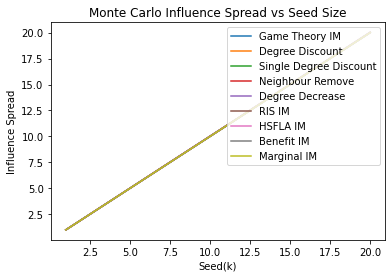

In [ ]:
plt.plot(k_array, influence_spread_GT, label = "Game Theory IM")
plt.plot(k_array, influence_spread_deg_discount, label = "Degree Discount")
plt.plot(k_array, influence_spread_si_deg_discount, label = "Single Degree Discount")
plt.plot(k_array, influence_spread_neighbour_remove, label = "Neighbour Remove")
plt.plot(k_array, influence_spread_degree_decrease, label = "Degree Decrease")
plt.plot(k_array, influence_spread_RIS, label = "RIS IM")
plt.plot(k_array, hslfa_influence_spread, label = "HSFLA IM")
plt.plot(k_array, b_influence_spread, label = "Benefit IM")
plt.plot(k_array, mi_influence_spread, label = "Marginal IM")
plt.title('Monte Carlo Influence Spread vs Seed Size')
plt.xlabel('Seed(k)')
plt.ylabel('Influence Spread')
plt.legend(loc='upper right')

In [ ]:
trace1 = go.Scatter(
x = k_array,
y = (influence_spread_GT),
mode = 'lines',
name = 'Game Theory IM'
)
trace2 = go.Scatter(
x = k_array,
y = (influence_spread_deg_discount),
mode = 'lines',
name = 'Degree Discount'
)
trace3 = go.Scatter(
x = k_array,
y = (influence_spread_si_deg_discount),
mode='lines',
name = 'Single Degree Discount'
)
trace4 = go.Scatter(
x = k_array,
y = (influence_spread_neighbour_remove),
mode='lines',
name = 'Neighbour Remove'
)
trace5 = go.Scatter(
x = k_array,
y = (influence_spread_degree_decrease),
mode='lines',
name = 'Degree Decrease'
)
trace6 = go.Scatter(
x = k_array,
y = (influence_spread_RIS),
mode='lines',
name = 'RIS IM'
)
trace7 = go.Scatter(
x = k_array,
y = (b_influence_spread),
mode='lines',
name = 'Benefit IM'
)
trace8 = go.Scatter(
x = k_array,
y = (mi_influence_spread),
mode='lines',
name = 'Marginal IM'
)
trace9 = go.Scatter(
x = k_array,
y = (hslfa_influence_spread),
mode='lines',
name = 'HSFLA IM'
    
)
layout = go.Layout(
title = "Monte Carlo influence Spread vs Seed Size",
xaxis = {'title' : "Seed(k)"},
yaxis = {'title' : "Influence Spread"}
)
fig = go.Figure(data=[trace1, trace2, trace3,trace4,trace5,trace6,trace9,trace7,trace8], layout=layout)
# fig = go.Figure(data=[ trace2, trace3,trace7], layout=layout)
fig.show()

In [ ]:
def cummulativeMIScore(node_list):
  temp_marginal_score = []
  temp_benefit_score = []
  temp_loss_score = []
  prev_ms= 0 ;
  prev_bs= 0 ;
  prev_ls= 0 ;
  #tot_ms,tot_bs,tot_ls = 0,0,0
  k=3;
  for node in (node_list):
    ms = benefit[node][k] - loss[node][k]
    bs = benefit[node][k]
    ls = loss[node][k]
    temp_marginal_score.append(ms+prev_ms)
    temp_benefit_score.append(bs+prev_bs)
    temp_loss_score.append(ls+prev_ls)
    
    #prev_ms = ms;
    #prev_bs = bs;
    #prev_ls = ls;
    prev_ms = ms+prev_ms;
    prev_bs = bs+prev_bs;
    prev_ls = ls+prev_ls;
    
  return (temp_marginal_score,temp_benefit_score,temp_loss_score);

Nodes of Degree Decrease Algo and Neighbour Remove Algo -- From Hari

In [ ]:
S_neighbour_remove_nodes = [5848246,5808797,5841579,5797877,5610317,5792534,5747594,5773106,5681380,5563042,5582923,5395471,5848143,5683370,5675216,5834824,5550746,5755687,5818820,5822436]
S_deg_decrease_nodes=[ 5848246,5808797,5841579,5797877,5610317,5792534,5747594,5773106,5681380,5563042,5582923,5395471,5848143,5683370,5675216,5834824,5550746,5755687,5818820,5822436 ]

In [ ]:
# cum_mi_list_MIM, benefit_list_MIM, loss_list_MIM = cummulativeMIScore(top_marginal_nodes)
# cum_mi_list_game_theory,benefit_list_game_theory,loss_list_game_theory = cummulativeMIScore(imlist)
# cum_mi_list_deg_discount,benefit_list_deg_discount,loss_list_deg_discount = cummulativeMIScore(S_deg_discount)
# cum_mi_list_sin_deg_discount, benefit_list_sin_deg_discount,loss_list_sin_deg_discount = cummulativeMIScore(S_sin_deg_discount)
# cum_mi_list_deg_decrease, benefit_list_deg_decrease,loss_list_deg_decrease = cummulativeMIScore(S_deg_decrease_nodes)
# cum_mi_list_neighbour_remove, benefit_list_neighbour_remove,loss_list_neighbour_remove = cummulativeMIScore(S_neighbour_remove_nodes)
# cum_mi_list_RIS, benefit_list_RIS,loss_list_RIS = cummulativeMIScore(ris_list)

In [ ]:
cum_mi_list_MIM, benefit_list_MIM, loss_list_MIM = cummulativeMIScore(top_marginal_nodes)
cum_mi_list_BIM, benefit_list_BIM, loss_list_BIM = cummulativeMIScore(top_benefit_nodes)
cum_mi_list_game_theory,benefit_list_game_theory,loss_list_game_theory = cummulativeMIScore(imlist)
cum_mi_list_deg_discount,benefit_list_deg_discount,loss_list_deg_discount = cummulativeMIScore(S_deg_discount)
cum_mi_list_sin_deg_discount, benefit_list_sin_deg_discount,loss_list_sin_deg_discount = cummulativeMIScore(S_sin_deg_discount)
cum_mi_list_deg_decrease, benefit_list_deg_decrease,loss_list_deg_decrease = cummulativeMIScore(S_deg_decrease_nodes)
cum_mi_list_neighbour_remove, benefit_list_neighbour_remove,loss_list_neighbour_remove = cummulativeMIScore(S_neighbour_remove_nodes)
cum_mi_list_RIS, benefit_list_RIS,loss_list_RIS = cummulativeMIScore(ris_list)
cum_mi_list_HSFLA, benefit_list_HSFLA,loss_list_HSFLA = cummulativeMIScore(hslfa_im_nodes)

In [ ]:
cum_mi_list_MIM

[1.4169772791135926e-06,
 2.367927325977353e-06,
 3.2621884215004306e-06,
 4.12994559413901e-06,
 4.989236172388977e-06,
 5.838096684621955e-06,
 6.680331593596745e-06,
 7.497044047927815e-06,
 8.26933821392509e-06,
 9.035006630904304e-06,
 9.792627792158779e-06,
 1.0532773911781103e-05,
 1.1272919994947025e-05,
 1.2013065642137225e-05,
 1.2727689125351742e-05,
 1.3436668079242562e-05,
 1.4125769709031351e-05,
 1.4814871273044938e-05,
 1.5503972810505098e-05,
 1.618178522270661e-05]

In [ ]:
avg_mi_MIM = max(cum_mi_list_MIM)/20
max_mi = max(max(cum_mi_list_BIM)/20, max(cum_mi_list_game_theory)/20, 
    max(cum_mi_list_deg_discount)/20, max(cum_mi_list_sin_deg_discount)/20,
    max(cum_mi_list_deg_decrease)/20, max(cum_mi_list_neighbour_remove)/20,
    max(cum_mi_list_RIS)/20, max(cum_mi_list_HSFLA)/20)
avg_mi_MIM, max_mi, avg_mi_MIM/max_mi 

(8.090892611353305e-07, 2.359654000881385e-07, 3.4288470294081974)

In [ ]:
avg_mi_BIM = max(benefit_list_BIM)/20
max_bi = max(max(benefit_list_MIM)/20, max(benefit_list_game_theory)/20, 
    max(benefit_list_deg_discount)/20, max(benefit_list_sin_deg_discount)/20,
    max(benefit_list_deg_decrease)/20, max(benefit_list_neighbour_remove)/20,
    max(benefit_list_RIS)/20, max(benefit_list_HSFLA)/20)
avg_mi_BIM, max_bi, avg_mi_BIM/max_bi

(1.0249531426985896e-06, 8.571773001520693e-07, 1.1957306178275553)

In [ ]:
avg_mi_LIM = max(loss_list_MIM)/20
max_li = min(max(loss_list_BIM)/20, max(loss_list_game_theory)/20, 
    max(loss_list_deg_discount)/20, max(loss_list_sin_deg_discount)/20,
    max(loss_list_deg_decrease)/20, max(loss_list_neighbour_remove)/20,
    max(loss_list_RIS)/20, max(loss_list_HSFLA)/20)
avg_mi_LIM, max_li, avg_mi_LIM/max_li

(4.808803901673869e-08, 1.040295106141915e-08, 4.622538232932783)

Graph for Cummulative Marginal Influence Score Vs Seed Size

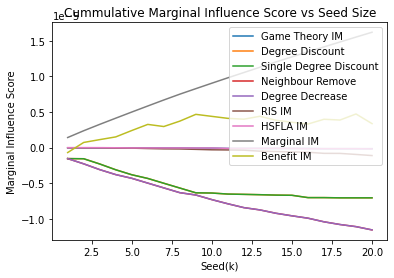

In [ ]:
plt.plot(k_array, cum_mi_list_game_theory, label = "Game Theory IM")
plt.plot(k_array, cum_mi_list_deg_discount, label = "Degree Discount")
plt.plot(k_array, cum_mi_list_sin_deg_discount, label = "Single Degree Discount")
plt.plot(k_array, cum_mi_list_neighbour_remove, label = "Neighbour Remove")
plt.plot(k_array, cum_mi_list_deg_decrease, label = "Degree Decrease")
plt.plot(k_array, cum_mi_list_RIS, label = "RIS IM")
plt.plot(k_array, cum_mi_list_HSFLA, label = "HSFLA IM")
plt.plot(k_array, cum_mi_list_MIM, label = "Marginal IM")
plt.plot(k_array, cum_mi_list_BIM, label = "Benefit IM")
plt.title('Cummulative Marginal Influence Score vs Seed Size')
plt.xlabel('Seed(k)')
plt.ylabel('Marginal Influence Score')
plt.legend(loc='upper right')

In [ ]:
trace1 = go.Scatter(
x = k_array,
y = exp(cum_mi_list_game_theory),
mode = 'lines',
name = 'Game Theory IM'
)
trace2 = go.Scatter(
x = k_array,
y = exp(cum_mi_list_deg_discount),
mode = 'lines',
name = 'Degree Discount'
)
trace3 = go.Scatter(
x = k_array,
y = exp(cum_mi_list_sin_deg_discount),
mode='lines',
name = 'Single Degre Discount'
)
trace4 = go.Scatter(
x = k_array,
y = exp(cum_mi_list_neighbour_remove),
mode='lines',
name = 'Neighbour Remove'
)
trace5 = go.Scatter(
x = k_array,
y = exp(cum_mi_list_deg_decrease),
mode='lines',
name = 'Degree Decrease'
)
trace6 = go.Scatter(
x = k_array,
y = exp(cum_mi_list_RIS),
mode='lines',
name = 'RIS IM'
)
trace7 = go.Scatter(
x = k_array,
y = exp(cum_mi_list_MIM),
mode='lines',
name = 'Marginal IM'
)
trace8 = go.Scatter(
x = k_array,
y = exp(cum_mi_list_BIM),
mode='lines',
name = 'Benefit IM'
)
trace9 = go.Scatter(
x = k_array,
y = exp(cum_mi_list_HSFLA),
mode='lines',
name = 'HSFLA IM'
)
layout = go.Layout(
title = "Cummulative Exponential Marginal Influence Score vs Seed Size",
xaxis = {'title' : "Seed(k)"},
yaxis = {'title' : "Marginal Influence Score"}
)
fig = go.Figure(data=[trace1, trace2, trace3,trace4,trace5,trace6,trace9, trace7,trace8], layout=layout)
fig.show()

Graph for Cummulative Exponential and Non Exponential Benefit Influence Score Vs Seed Size

In [ ]:
trace1 = go.Scatter(
x = k_array,
y = exp(benefit_list_game_theory),
mode = 'lines',
name = 'Game Theory IM'
)
trace2 = go.Scatter(
x = k_array,
y = exp(benefit_list_deg_discount),
mode = 'lines',
name = 'Degree Discount'
)
trace3 = go.Scatter(
x = k_array,
y = exp(benefit_list_sin_deg_discount),
mode='lines',
name = 'Single Degree Discount'
)
trace4 = go.Scatter(
x = k_array,
y = exp(benefit_list_neighbour_remove),
mode='lines',
name = 'Neighbour Remove'
)
trace5 = go.Scatter(
x = k_array,
y = exp(benefit_list_deg_decrease),
mode='lines',
name = 'Degree Decrease'
)
trace6 = go.Scatter(
x = k_array,
y = exp(benefit_list_RIS),
mode='lines',
name = 'RIS IM'
)
trace7 = go.Scatter(
x = k_array,
y = exp(benefit_list_MIM),
mode='lines',
name = 'Marginal IM'
)
trace8 = go.Scatter(
x = k_array,
y = exp(benefit_list_BIM),
mode='lines',
name = 'Benefit IM'
)
trace9 = go.Scatter(
x = k_array,
y = exp(benefit_list_HSFLA),
mode='lines',
name = 'HSFLA IM'
)
layout = go.Layout(
title = "Cummulative Exponential Benefit Influence Score vs Seed Size",
xaxis = {'title' : "Seed(k)"},
yaxis = {'title' : "Exponential Benefit Influence Score"}
)
fig = go.Figure(data=[trace1, trace2, trace3,trace4,trace5,trace6,trace9, trace7, trace8], layout=layout)
fig.show()

In [ ]:
trace1 = go.Scatter(
x = k_array,
y = (benefit_list_game_theory),
mode = 'lines',
name = 'Game Theory IM'
)
trace2 = go.Scatter(
x = k_array,
y = (benefit_list_deg_discount),
mode = 'lines',
name = 'Degree Discount'
)
trace3 = go.Scatter(
x = k_array,
y = (benefit_list_sin_deg_discount),
mode='lines',
name = 'Single Degree Discount'
)
trace4 = go.Scatter(
x = k_array,
y = (benefit_list_neighbour_remove),
mode='lines',
name = 'Neighbour Remove'
)
trace5 = go.Scatter(
x = k_array,
y = (benefit_list_deg_decrease),
mode='lines',
name = 'Degree Decrease'
)
trace6 = go.Scatter(
x = k_array,
y = (benefit_list_RIS),
mode='lines',
name = 'RIS IM'
)
trace7 = go.Scatter(
x = k_array,
y = (benefit_list_MIM),
mode='lines',
name = 'Marginal IM'
)
trace8 = go.Scatter(
x = k_array,
y = (benefit_list_BIM),
mode='lines',
name = 'Benefit IM'
)
trace9 = go.Scatter(
x = k_array,
y = (benefit_list_HSFLA),
mode='lines',
name = 'HSFLA IM'
)
layout = go.Layout(
title = "Cummulative Benefit Influence Score vs Seed Size",
xaxis = {'title' : "Seed(k)"},
yaxis = {'title' : "Benefit Influence Score"}
)
fig = go.Figure(data=[trace1, trace2, trace3,trace4,trace5,trace6,trace9,trace7,trace8], layout=layout)
fig.show()

Graph for Cummulative Exponential and Non Exponential Negative Influence Score Vs Seed Size

In [ ]:
trace1 = go.Scatter(
x = k_array,
y = exp(loss_list_game_theory),
mode = 'lines',
name = 'Game Theory IM'
)
trace2 = go.Scatter(
x = k_array,
y = exp(loss_list_deg_discount),
mode = 'lines',
name = 'Degree Discount'
)
trace3 = go.Scatter(
x = k_array,
y = exp(loss_list_sin_deg_discount),
mode='lines',
name = 'Single Degree Discount'
)
trace4 = go.Scatter(
x = k_array,
y = exp(loss_list_neighbour_remove),
mode='lines',
name = 'Neighbour Remove'
)
trace5 = go.Scatter(
x = k_array,
y = exp(loss_list_deg_decrease),
mode='lines',
name = 'Degree Decrease'
)
trace6 = go.Scatter(
x = k_array,
y = exp(loss_list_RIS),
mode='lines',
name = 'RIS IM'
)
trace7 = go.Scatter(
x = k_array,
y = exp(loss_list_MIM),
mode='lines',
name = 'Marginal IM'
)
trace8 = go.Scatter(
x = k_array,
y = exp(loss_list_BIM),
mode='lines',
name = 'Benefit IM'
)
trace9 = go.Scatter(
x = k_array,
y = exp(loss_list_HSFLA),
mode='lines',
name = 'HSFLA IM'
)
layout = go.Layout(
title = "Cummulative Exponential Negative Influence Score vs Seed Size",
xaxis = {'title' : "Seed(k)"},
yaxis = {'title' : "Exponential Negative Influence Score"}
)
fig = go.Figure(data=[trace1, trace2, trace3,trace4,trace5,trace6,trace9,trace7,trace8], layout=layout)
fig.show()

In [ ]:
trace1 = go.Scatter(
x = k_array,
y = (loss_list_game_theory),
mode = 'lines',
name = 'Game Theory IM'
)
trace2 = go.Scatter(
x = k_array,
y = (loss_list_deg_discount),
mode = 'lines',
name = 'Degree Discount'
)
trace3 = go.Scatter(
x = k_array,
y = (loss_list_sin_deg_discount),
mode='lines',
name = 'Single Degree Discount'
)
trace4 = go.Scatter(
x = k_array,
y = (loss_list_neighbour_remove),
mode='lines',
name = 'Neighbour Remove'
)
trace5 = go.Scatter(
x = k_array,
y = (loss_list_deg_decrease),
mode='lines',
name = 'Degree Decrease'
)
trace6 = go.Scatter(
x = k_array,
y = (loss_list_RIS),
mode='lines',
name = 'RIS IM'
)
trace7 = go.Scatter(
x = k_array,
y = (loss_list_MIM),
mode='lines',
name = 'Marginal IM'
)
trace8 = go.Scatter(
x = k_array,
y = (loss_list_BIM),
mode='lines',
name = 'Benefit IM'
)
trace9 = go.Scatter(
x = k_array,
y = (loss_list_HSFLA),
mode='lines',
name = 'HSFLA IM'
)
layout = go.Layout(
title = "Cummulative Negative Influence Score vs Seed Size",
xaxis = {'title' : "Seed(k)"},
yaxis = {'title' : "Negative Influence Score"}
)
fig = go.Figure(data=[trace1, trace2, trace3,trace4,trace5,trace6,trace9,trace7,trace8], layout=layout)
fig.show()

In [ ]:
import plotly.express as px
fig = px.bar(x=['Game Theory IM', 'Degree Discount', 'Single Degree Discount', 
           'Neighbor Remove', 'Degree Decrease', 'RIS IM', 'HSFLA IM', 'Marginal/Benefit IM'],
        y=[784.0, 12.781, 30.06, 15.342, 18.466, 665.3239, 3000, 67.531],
        title="Running time of algorithms on US Patent Dataset")
fig.update_xaxes(type='category')
fig.show()

Calculating the sum of marginal scores for the nodes obtained by our algo and IM algo

In [ ]:
tot_ms = 0
tot_im = 0
for i in imlist:
  tot_im = tot_im + marginal_score[i] 
for i in top_marginal_nodes:
  tot_ms = tot_ms + marginal_score[i]

IndexError: ignored

In [ ]:
print(tot_im)
print(tot_ms)

In [ ]:
thresh = 0.5
matching_nodes = []
for node in G.nodes():
  if G.nodes[node]['Matching Score'] > thresh:
    matching_nodes.append(node)

Algo 1 --> Compute BL Score
Returns Node  having highest B-L Score from the social Network


In [ ]:
def computeBLScore(G2, alpha = opt_alpha, beta = opt_beta, lamda = opt_lambda, query = 5855020 ):
  temp_G = G2.copy()
  error = 1
  threshold = 10 ** (-10)
  k=0;
  V = temp_G.number_of_nodes()
  E = temp_G.number_of_edges()
  benefit2 = [[] for _ in range(max_patent+1)]
  loss2 = [[] for _ in range(max_patent+1)]
  for node in G.nodes():
    benefit2[node].append(0)
    loss2[node].append(0)
  while error > threshold:
    k+=1;
    for node in temp_G.nodes():
      benefit2[node].append(0)
      loss2[node].append(0);
      neighbour_list = list(temp_G.neighbors(node))
      for neighbour in neighbour_list:
        benefit2[node][k] += (temp_G[node][neighbour]['weight'])*(1-lamda)*(alpha*benefit2[neighbour][k-1] + (1-alpha)*temp_G.nodes[neighbour]['Matching Score'])/E
        loss2[node][k] += (temp_G[node][neighbour]['weight'])*(beta*loss2[neighbour][k-1] + (1-beta)*(1-temp_G.nodes[neighbour]['Matching Score']))/E
  ## query node 
    benefit2[query][k] += lamda/V;
    error = 0;
    for i in temp_G.nodes():
      error += ((benefit2[i][k]-benefit2[i][k-1])**2 + (loss2[i][k]-loss2[i][k-1])**2)
    error = error ** 0.5
  best_ms = -1
  best_marginal_node = -1
  for node in temp_G.nodes():
    ms = benefit2[node][k] - loss2[node][k]
    if ms > best_ms and node!= query:
      best_ms = ms
      best_marginal_node = node

  return best_marginal_node;


In [ ]:
G2 = G.copy()

In [ ]:
def MSI(opt_alpha = opt_alpha, opt_beta = opt_beta, opt_lambda = opt_lambda, budget = 5):
  msi_list = []
  for i in range(1, budget+1):
    x = computeBLScore(G2,opt_alpha,opt_beta,opt_lambda)
    neighbour_list = list(G2.neighbors(x))
    for y in neighbour_list:
      if G2.has_edge(y,x):
        G2.remove_edge(y,x)
      if G2.has_edge(x,y):
        G2.remove_edge(x,y)
    G2.remove_node(x)
    print(x)
    msi_list.append(x)
  return msi_list

In [ ]:
opt_alpha,opt_beta,opt_lambda

(0.8453801496643429, 0.9013537521030607, 0.25)

In [ ]:
msi_list = []
msi_list  = MSI()

5015595
4567640
5432103
5234847
5413966


In [ ]:
# budget = 15
# msi_list = []
# for i in range(1, budget+1):
#   x = computeBLScore(G2)
#   neighbour_list = list(G2.neighbors(x))
#   for y in neighbour_list:
#     if G2.has_edge(y,x):
#       G2.remove_edge(y,x)
#     if G2.has_edge(x,y):
#       G2.remove_edge(x,y)
#   G2.remove_node(x)
#   print(x)
#   msi_list.append(x)


4925806
5409845
4713329
5015595
4567640
5747359
5234847
4701423
5024959
4902640
5432103
5063168
5783470
4546535
4636834


In [ ]:
msi_list

In [ ]:
G_mti = G.copy()

In [ ]:
budget = 5
mti_list = []
l = []

In [ ]:
nx.is_directed(G_mti)

True

In [ ]:
for i in range(1, budget+1):
  print(G_mti.number_of_nodes())
  x = computeBLScore(G_mti)
  mti_list.append(x)
  l.append(x)
  while len(l)>0:
    y = l[0]
    neighbour_list = list(G_mti.neighbors(y))   
    for z in neighbour_list:
      test_set = set(l)
      if z not in test_set:
        l.append(z)
      if G_mti.has_edge(y,z):
        G_mti.remove_edge(y,z)
      if G_mti.has_edge(z,y):
        G_mti.remove_edge(z,y)
    # G_mti.remove_node(y)
    l.pop(0)
      # if G_mti.has_edge(z,y):
      #   l.append(z)
      #   G_mti.remove_edge(z,y)
    # G_mti.remove_node(y)

633587
633587
633587
633587
633587


In [ ]:
mti_list

[4925806, 5409845, 5063168]

In [ ]:
for node in msi_list:
  print(G.nodes[node]['title']+","+str(node))

Semiconductor Device Manufacturing: Process,5015595
Semiconductor Device Manufacturing: Process,4567640
Semiconductor Device Manufacturing: Process,5432103
Semiconductor Device Manufacturing: Process,5234847
Semiconductor Device Manufacturing: Process,5413966


In [ ]:
for node in mtmi_list:
  print(G.nodes[node]['title']+","+str(node))


Active Solid-State Devices (e.g., Transistors, Solid-State Diodes),5557131
Semiconductor Device Manufacturing: Process,5747359
Semiconductor Device Manufacturing: Process,5413966
Semiconductor Device Manufacturing: Process,5432103
Semiconductor Device Manufacturing: Process,5234847


**Color Code**
1.   Yellow : MSI and MTI
2.   Red: MSI
3.   Green : MTI
4.   Blue: Neither 

In [ ]:
for node in G.nodes():
  if node in msi_list and node in mti_list:
    G.nodes[node]['colour'] = 'yellow'
  elif node in msi_list:
    G.nodes[node]['colour'] = 'red'
  elif node in mti_list:
    G.nodes[node]['colour'] = 'green'
  else:
    G.nodes[node]['colour'] = 'blue'

In [ ]:
nx.write_gexf(G, "Patent.gexf")

In [ ]:
hard_msi_list = [5015595,4567640,5432103,5234847,5413966]
hard_mti_list = [5557131,5747359,5413966,5432103,5234847]
for node in G.nodes():
  if node in hard_msi_list and node in hard_mti_list:
    G.nodes[node]['colour'] = 'yellow'
  elif node in hard_msi_list:
    G.nodes[node]['colour'] = 'red'
  elif node in hard_mti_list:
    G.nodes[node]['colour'] = 'green'
  else:
    G.nodes[node]['colour'] = 'blue'

In [ ]:
nx.write_gexf(G, "Patent.gexf")

In [ ]:
for node_marg in top_marginal_nodes:
  print(G.nodes[node_marg]['title']+","+str(node_marg))

Semiconductor Device Manufacturing: Process,4925806
Semiconductor Device Manufacturing: Process,5409845
Semiconductor Device Manufacturing: Process,5063168
Semiconductor Device Manufacturing: Process,4713329
Active Solid-State Devices (e.g., Transistors, Solid-State Diodes),5557131
Semiconductor Device Manufacturing: Process,5747359
Semiconductor Device Manufacturing: Process,5015595
Semiconductor Device Manufacturing: Process,4567640
Semiconductor Device Manufacturing: Process,5432103
Semiconductor Device Manufacturing: Process,5234847
Semiconductor Device Manufacturing: Process,5413966
Semiconductor Device Manufacturing: Process,4701423
Semiconductor Device Manufacturing: Process,5024959
Semiconductor Device Manufacturing: Process,4902640
Semiconductor Device Manufacturing: Process,5783470
Active Solid-State Devices (e.g., Transistors, Solid-State Diodes),5166771
Semiconductor Device Manufacturing: Process,4546535
Semiconductor Device Manufacturing: Process,5298440
Active Solid-State

In [ ]:
for node_bene in top_benefit_nodes:
  print(G.nodes[node_bene]['title']+","+str(node_bene))

Telecommunications,5771455
Semiconductor Device Manufacturing: Process,4925806
Semiconductor Device Manufacturing: Process,5780323
Active Solid-State Devices (e.g., Transistors, Solid-State Diodes),5763898
Semiconductor Device Manufacturing: Process,5063168
Active Solid-State Devices (e.g., Transistors, Solid-State Diodes),5557131
Multiplex Communications,5818820
Semiconductor Device Manufacturing: Process,5413966
Semiconductor Device Manufacturing: Process,5409845
Multiplex Communications,5768264
Multiplex Communications,5787076
Telecommunications,5815799
Active Solid-State Devices (e.g., Transistors, Solid-State Diodes),5789764
Telecommunications,5734981
Pulse or Digital Communications,5815525
Multiplex Communications,5671219
Semiconductor Device Manufacturing: Process,5248625
Telecommunications,5613196
Semiconductor Device Manufacturing: Process,5747359
Chemistry: Analytical and Immunological Testing,5607863


In [ ]:
mi_nodes = []
top_k_mi_nodes = []
threshold = 0.9999
for nodes in G.nodes():
  if G.nodes[nodes]['Matching Score'] > threshold:
    mi_nodes.append(nodes)

top_k_mi_nodes = random.sample(mi_nodes, 5)
for node in top_k_mi_nodes:
  print(G.nodes[node]['title']+","+str(node))

Semiconductor Device Manufacturing: Process,4259366
Semiconductor Device Manufacturing: Process,4702792
Semiconductor Device Manufacturing: Process,5466626
Semiconductor Device Manufacturing: Process,5264380
Semiconductor Device Manufacturing: Process,4968628
